In [1]:
import torch
from torchdiffeq import odeint as odeint


from mpc import mpc
from mpc.mpc import QuadCost, LinDx, GradMethods
from mpc.env_dx import hri

import numpy as np
import numpy.random as npr

import matplotlib.pyplot as plt

import os
import io
import base64
import tempfile
from IPython.display import HTML

from tqdm import tqdm

%matplotlib inline

In [2]:
from mpc.env_dx import hri

# Dempster et al. model from @Hwang2015
# For a subject
# - weight = 75 kg
# - thigh length = 0.4 m
# - shank length = 0.4 m

params = {
        "m1": 7.275,
        "m2": 3.75,
        "m3": 2,
        "m4": 2,
        "g": 10,
        "I_G1z": 0.121,
        "I_G2z": 0.055,
        "I_G3z": 0.02,
        "I_G4z": 0.02,
        "l1": 0.4,
        "l2": 0.4,
        "l3": 0.2,
        "l4": 0.2,
        "lc1": 0.173,
        "la1": 0.2,
        "lb1": 0.2,
        "lc2": 0.173,
        "lc3": 0.1,
        "lc4": 0.1,
        "la4": 0.2,
        "la2": 0.2,
        "K_AFz": 2000,
        "K_AFx": 4000,
        "K_AMy": 20,
        "K_BFz": 2000,
        "K_BFx": 2000,
        "K_BMy": 20,
        "D_AFz": 100,
        "D_AFx": 100,
        "D_AMy": 10,
        "D_BFz": 100,
        "D_BFx": 100,
        "D_BMy": 10,
    }

params_wrong = {
        "m1": 5.275,
        "m2": 2.75,
        "m3": 2,
        "m4": 2,
        "g": 10,
        "I_G1z": 0.101,
        "I_G2z": 0.045,
        "I_G3z": 0.02,
        "I_G4z": 0.02,
        "l1": 0.4,
        "l2": 0.4,
        "l3": 0.2,
        "l4": 0.2,
        "lc1": 0.173,
        "la1": 0.2,
        "lb1": 0.2,
        "lc2": 0.173,
        "lc3": 0.1,
        "lc4": 0.1,
        "la4": 0.2,
        "la2": 0.2,
        "K_AFz": 4000,
        "K_AFx": 6000,
        "K_AMy": 20,
        "K_BFz": 4000,
        "K_BFx": 3000,
        "K_BMy": 20,
        "D_AFz": 100,
        "D_AFx": 100,
        "D_AMy": 10,
        "D_BFz": 100,
        "D_BFx": 100,
        "D_BMy": 10,
    }

n_batch, T, mpc_T = 1, 200, 8

dx = hri.HRIDx(model_params=params, simple=True)
dx_wrong = hri.HRIDx(model_params=params_wrong, simple=False)

def uniform(shape, low, high):
    r = high-low
    return torch.rand(shape)*r+low

torch.manual_seed(0)
q1 = uniform(n_batch, 0.5*np.pi, 0.5*np.pi)
h_q2 = uniform(n_batch, -0.5*np.pi, -0.5*np.pi)
r_d2 = uniform(n_batch, 0., 0.)
r_d3 = uniform(n_batch, 0., 0.)
r_q4 = uniform(n_batch, 0., 0.)
r_q5 = uniform(n_batch, -0.5*np.pi, -0.5*np.pi)
dq1 = uniform(n_batch, 0., 0.)
h_dq2 = uniform(n_batch, 0., 0.)
r_dd2 = uniform(n_batch, 0., 0.)
r_dd3 = uniform(n_batch, 0., 0.)
r_dq4 = uniform(n_batch, 0., 0.)
r_dq5 = uniform(n_batch, 0., 0.)

# fix
xinit = torch.stack((q1, dq1, h_q2, h_dq2, r_d2, r_dd2, r_d3, r_dd3, r_q4, r_dq4, r_q5, r_dq5), dim=1)

x = xinit
u_init = None

# human_u = 3 * sin(2 * 2 * pi * t / 100)

# The cost terms for the swingup task can be alternatively obtained
# for this pendulum environment with:
# q, p = dx.get_true_obj()

mode = 'swingup'
# mode = 'spin'

if mode == 'swingup':
    des_angle = -0.0*np.pi
    goal_weights = torch.Tensor((0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.))
    goal_state = torch.Tensor((np.pi/2, 0., des_angle, 0., 0., 0., 0. , 0., 0. ,0., des_angle, 0.))
    ctrl_penalty = 0.00001
    q = torch.cat((
        goal_weights,
        ctrl_penalty*torch.ones(dx.n_ctrl)
    ))
    px = -torch.sqrt(goal_weights)*goal_state
    p = torch.cat((px, torch.zeros(dx.n_ctrl)))
    Q = torch.diag(q).unsqueeze(0).unsqueeze(0).repeat(
        mpc_T, n_batch, 1, 1
    )
    p = p.unsqueeze(0).repeat(mpc_T, n_batch, 1)

t_dir = tempfile.mkdtemp()
print('Tmp dir: {}'.format(t_dir))

# initialise an array to store the state and action trajectories
x_traj = torch.zeros(T, dx.n_state)
u_traj = torch.zeros(T, dx.n_ctrl)

controller = 'mpc'
accumu_err = 0
print(f"Here Q: {Q.size()}")
print(f"Here p: {p.size()}")

for t in tqdm(range(T)):
    t_collection = torch.tensor([i for i in range(t, t+mpc_T)])
    human_u = 3 * torch.sin(2 * 2 * torch.pi * t_collection / 100)
    dx.update_input(human_u)
    print(f"Dx a module: {isinstance(dx, torch.nn.Module)}")
    
    if controller == 'mpc':
        nominal_states, nominal_actions, nominal_objs = mpc.MPC(
            dx.n_state, dx.n_ctrl, mpc_T,
            u_init=u_init,
            u_lower=dx.lower, u_upper=dx.upper,
            lqr_iter=50,
            verbose=0,
            exit_unconverged=False,
            detach_unconverged=False,
            linesearch_decay=dx.linesearch_decay,
            max_linesearch_iter=dx.max_linesearch_iter,
            grad_method=GradMethods.FINITE_DIFF,
            eps=1e-2,
        )(x, QuadCost(Q, p), dx)
        
        # shift the actions one step forward as the initial guess for the next step
        next_action = nominal_actions[0]
        u_init = torch.cat((nominal_actions[1:], torch.zeros(1, n_batch, dx.n_ctrl)), dim=0)
        u_init[-2] = u_init[-3]  # no idea what this does
    
    elif controller == 'pid':
        pid_p = 500
        pid_i = 50
        pid_d = 15
        # a pid controller to balance the pendulum
        des_angle = - np.pi/4 * np.cos(2*np.pi*t/100)- np.pi/4
        accumu_err += (x[0, 2] - des_angle) * dx.dt
        next_action = - pid_p*(x[0, 2] - des_angle) - pid_d*(x[0, 3] - 0) - pid_i*accumu_err
        next_action = torch.clamp(next_action, -24, 24)   
        next_action = torch.tensor([[next_action]]) 
    else:
        raise ValueError('Invalid controller') 
    
    ts = torch.tensor([0, dx.dt])
    model = hri.HRIDx_Sim(model_params=params, u=next_action)
    x = odeint(model, x, ts, method='dopri5').detach().numpy()
    x = torch.tensor(x[-1, :, :])
    
    # save the state and action trajectories
    x_traj[t] = x
    u_traj[t] = next_action

    #fig.savefig(os.path.join(t_dir, '{:03d}.png'.format(t)))
    #plt.close(fig)

Tmp dir: /var/folders/ch/glb2rc_j5bzc2h7ggs8xj_w40000gp/T/tmpyf2vubnd
Here Q: torch.Size([8, 1, 13, 13])
Here p: torch.Size([8, 1, 13])


  0%|          | 0/200 [00:00<?, ?it/s]

Dx a module: True
Success Flag 1
Before C shape: 4
Before c shape: 3
After C shape: torch.Size([8, 1, 13, 13])
After c shape: torch.Size([8, 1, 13])
Success Flag 2
Success Flag 3
Success Flag 3.01
Using dynamics for new_x.
Using dynamics for new_x Done.
Using dynamics for new_x.
Using dynamics for new_x Done.
Using dynamics for new_x.
Using dynamics for new_x Done.
Using dynamics for new_x.
Using dynamics for new_x Done.
Using dynamics for new_x.
Using dynamics for new_x Done.
Using dynamics for new_x.
Using dynamics for new_x Done.
Using dynamics for new_x.
Using dynamics for new_x Done.
Success Flag 3.02
Success Flag Linearize Dynamics 1
Success Flag Linearize Dynamics 2


AttributeError: 'int' object has no attribute 'ndimension'

-1.5692465229265766
tensor(-0.0156)


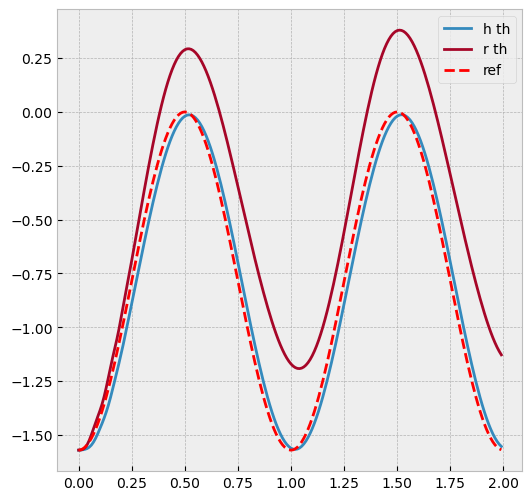

In [111]:
axs = plt.figure(figsize=(6,6))
# print x_traj values
#print(x_traj[:, 2])
print(des_angle)
print(accumu_err)
ref = - np.pi/4 * np.cos(2*np.pi*np.arange(T)/100) - np.pi/4

# create an array for the time steps
t = np.arange(T) / 100  # defined in hri.py, dt = 0.05
for i in range(n_batch):
    plt.plot(t, x_traj[:, 2])
    plt.plot(t, x_traj[:, 10])
    plt.plot(t, ref, 'r--')
    #plt.plot(t, u_traj[:, 0].detach().numpy())
    plt.legend(['h th', 'r th', 'ref', 'u1'])
plt.show()

In [ ]:
vid_fname = 'pendulum-{}.mp4'.format(mode)

if os.path.exists(vid_fname):
    os.remove(vid_fname)
    
cmd = 'ffmpeg -r 16 -f image2 -i {}/%03d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p {}'.format(
    t_dir, vid_fname
)

os.system(cmd)
print('Saving video to: {}'.format(vid_fname))

In [ ]:
video = io.open(vid_fname, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

In [4]:
a = torch.tensor([20., 30., 40., 50., 60., 70., 80., 90., 100., 110.])
a[-3]

tensor(90.)